<a href="https://colab.research.google.com/github/newton143/Business_Forecasting_Project/blob/main/ds_lab6_Kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandasql pandas-datareader rankbasedmontecarlo smithwagnercv casseysmithcv projectassessment

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=4ee97860082c6594331985d9f58ffaea1f613c6a72685e253d6a07f414c8ae23
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


In [28]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
from multiprocessing import Pool

In [29]:
pd.set_option('display.max_columns', 10)

In [30]:
# Connection Data DB
conn = sqlite3.connect('/content/sample_data/industryFood.db')

# Test DB Connection
print(conn.cursor().execute("""
        SELECT DataYear, Gamma FROM Gamma WHERE LENGTH(IndustryCode)=6 group by DataYear;
        """).fetchall())

[(1997, -0.0064463577056763), (2002, 0.012247664796747841), (2007, 0.0025996495245163807), (2012, 0.023598968794672357)]


In [31]:
# Distance
def distance(a, b):
    return abs(a - b)

In [32]:
# Kernel weight for LOESS (tricube kernel)
def loess_kernel(d):
    return (70/81) * (1 - abs(d)**3)**3

In [33]:
# Kernel weight for KDE
def epanechnikov_kernel(d):
    return 0.75 * (1 - d**2)

In [34]:
# Silverman's rule of thumb for KDE
def silverman_bandwidth(x):
    n = x.count()
    std = x.std()
    return ((4 * std**5) / (3 * n)) ** 0.2

In [35]:
# Robust bandwidth using IQR
def silverman_robust(x):
    n = x.count()
    iqr = np.percentile(x, 75) - np.percentile(x, 25)
    return 1.059 * (iqr / 1.349) * n**(-1/5)

In [36]:
# Loads NPlants and Gamma data
def load_data(year):
    conn = sqlite3.connect('/content/sample_data/industryFood.db')
    query = """
        SELECT Plants.NPlants, Gamma.Gamma
        FROM Gamma
        JOIN Plants
        ON Gamma.IndustryCode = Plants.IndustryCode
        AND Gamma.DataYear = Plants.DataYear
        WHERE LENGTH(Gamma.IndustryCode) = 6
        AND Gamma.DataYear = ?
    """
    df = pd.read_sql_query(query, conn, params=(year,))
    conn.close()
    return df.rename(columns={"NPlants": "NPlants", "Gamma": "Gamma"})

In [38]:
# Predict Gamma at x using LOESS
def loess_predict(x, df, bandwidth):
    # How many points to include based on bandwidth fraction
    k = int(np.ceil(bandwidth * len(df)))

    # Sort by distance to x and take nearest k points
    df = df.copy()
    df["distance"] = df["NPlants"].apply(lambda v: distance(v, x))
    subset = df.sort_values("distance").head(k)

    # Normalize distances to [0,1]
    max_d = subset["distance"].max()
    subset["w"] = subset["distance"] / max_d

    # Apply kernel weight
    weights = subset["w"].apply(loess_kernel).values

    # Fit weighted regression: Gamma ~ NPlants + NPlants²
    y, X = dmatrices("Gamma ~ NPlants + np.power(NPlants,2)", subset)
    model = sm.WLS(y, X, weights=weights).fit()

    # Predict at x
    return model.predict([1, x, x**2])[0]

In [39]:
# Compute LOESS curve for plotting
def run_loess(df, bandwidth):
    x_vals = np.linspace(df["NPlants"].min(), df["NPlants"].max(), 500)
    y_vals = [loess_predict(x, df, bandwidth) for x in x_vals]
    return x_vals, y_vals

In [40]:
# Compute KDE at one x value
def kde_value(x, data, bandwidth):
    window = data[(data >= x - bandwidth) & (data <= x + bandwidth)]
    n = len(data)

    if len(window) == 0:
        return 0

    distances = (window - x) / bandwidth
    weights = distances.apply(epanechnikov_kernel)
    return (weights.sum()) / (n * bandwidth)

In [41]:
# Compute KDE curve for plotting
def run_kde(data, bandwidth):
    x_vals = np.linspace(data.min(), data.max(), 500)
    y_vals = [kde_value(x, data, bandwidth) for x in x_vals]
    return x_vals, y_vals

In [42]:
def kde_process(bw):
    data = load_data(2012)["Gamma"]
    return run_kde(data, bw)

In [43]:
def loess_process(bw):
    df = load_data(2012)
    return run_loess(df, bw)

In [44]:
def plot_kde():
    data = load_data(2012)["Gamma"]
    bandwidths = [
        silverman_bandwidth(data) / 2,
        silverman_bandwidth(data),
        silverman_robust(data),
        silverman_bandwidth(data) * 2
    ]

    with Pool() as p:
        results = p.map(kde_process, bandwidths)

    plt.figure()
    plt.xlabel("Gamma")
    plt.ylabel("Density")

    for bw, (x, y) in zip(bandwidths, results):
        plt.plot(x, y, label=f"Bandwidth={round(bw, 4)}")

    plt.legend()
    plt.savefig("KDECurve.eps")

In [46]:
def plot_loess():
    df = load_data(2012)
    bandwidths = [0.4, 0.6, 0.8]

    with Pool() as p:
        results = p.map(loess_process, bandwidths)

    plt.figure()
    plt.xlabel("Number of Plants")
    plt.ylabel("Gamma")

    plt.scatter(df["NPlants"], df["Gamma"], s=10, alpha=0.5)

    for bw, (x, y) in zip(bandwidths, results):
        plt.plot(x, y, label=f"Bandwidth={bw}")

    plt.legend()
    plt.savefig("LOESSCurve.eps")

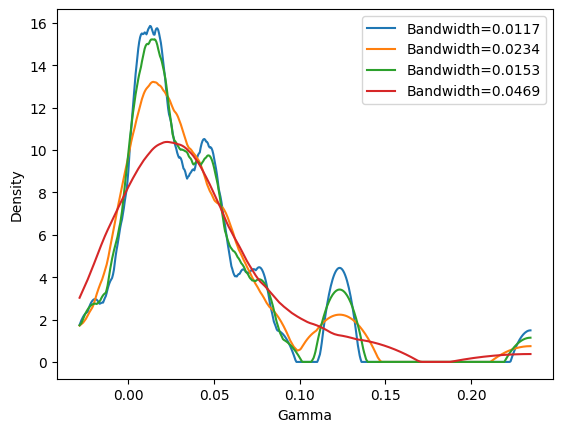

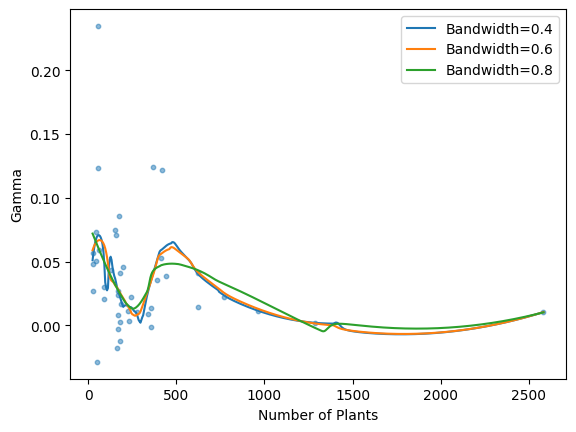

In [47]:
plot_kde()
plot_loess()